In [1]:
import os
import random
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show
import rioxarray as rxr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from joblib import Parallel, delayed
from tqdm import tqdm
from time import time, strftime, gmtime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import skew

In [2]:
########## Parameters ##########
n1 = str(20)              # Define a n° of neighbors # Available options: 8/14/20/24/34/38/44/62/80 # Default: 24
t = 0.008               # Lower distance Threshold
f = 0.8                 # how much of the training image will be searched (float number between 0 and 1)
n2 = 100                  # N° defined sub-groups
w1 = 0.5              # sum of w1 & w2 need to be equal to 1
w2 = 0.5
minNx = 3               # Min n° of neighbors for a selected UP before starting the algorithm

In [3]:
inputdir1 = r'G:\MScThesis\waterQualityMonitoring\Data\GapFilling\testingPhase_France\Target_Image\Step3_ApplyElevMask'
file_names = np.array([]).astype('str')
for file in os.listdir(inputdir1):
    if "tiff" in file:
        file_names = np.append(file_names, file)
        
inputdir2 = r'G:\MScThesis\waterQualityMonitoring\Data\GapFilling\testingPhase_France\Training_Images\Step3_ApplyElevMask'
file_names1 = np.array([]).astype('str')
for file in os.listdir(inputdir2):
    if "tiff" in file:
        file_names1 = np.append(file_names1, file)

In [4]:
########## Read as arrays ##########
band = 2              # b2:0/b3:1/b4:2/b5:3/b6:4/b7:5/b8:6/b8a:7
targetband = 10        # b2:0/b3:5/b4:10/b5:15/b6:20/b7:25/b8:30/b8a:35
c = 4                # 0 .. 4 (clouded1 .. clouded5)
img = rasterio.open(os.path.join(inputdir1, file_names[40+band]))
cloudFreeImg = rasterio.open(os.path.join(inputdir1, file_names[40+band])).read(1) 
targetImg = rasterio.open(os.path.join(inputdir1, file_names[targetband+c])).read(1)
my_array1 = rasterio.open(os.path.join(inputdir2, file_names1[0+band])).read(1) # image before target image
my_array2 = rasterio.open(os.path.join(inputdir2, file_names1[8+band])).read(1) # image after target image

########## Plot Histogram ##########
# sns.set(font_scale=1.5, style="whitegrid")                                   # Prettier plotting with seaborn
# fig, ax = plt.subplots(figsize=(5, 4))                                         # Set figure size
# Img = rxr.open_rasterio(os.path.join(inputdir1, file_names[1]), masked=True) # Target Image
# Img.plot.hist(ax=ax, color="green", bins=50)
# ax.set(title="Distribution of Reflectance Values", xlabel='Reflectance', ylabel='Frequency')
# plt.show()

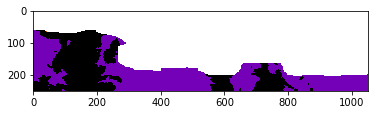

In [5]:
levels = [-99, 0, 250, 500, 750, 1000, 1250, 1500, 2000, 4000]
clrs = ['black','#7400b8','#6930c3','#5e60ce','#5390d9','#4ea8de','#e85d04','#f48c06', '#faa307', 'white']    
cmap, norm = colors.from_levels_and_colors(levels,clrs,extend='max')
show(targetImg,cmap=cmap,norm=norm,interpolation='bilinear')

In [3]:
def get_coordKP(item, array):    
    if array[item[0],item[1]] != -99:
        return item
########## Get coordUP & Get coordKP of TargetImg ##########
coordMP = np.argwhere(targetImg < 1e+36).tolist()                # MP: Mixed Pixels
coord_KP = Parallel(n_jobs=-1)(delayed(get_coordKP)(coordMP[k],targetImg) for k in range(len(coordMP)))
coordKP = [x for x in coord_KP if x != None]                  # KP: Known Pixels

coordUP = np.argwhere(targetImg == -99).tolist()                    # UP: Unknown Pixels

########## Identify auxiliary image to be used ##########
coordMP_arr1 = np.argwhere(my_array1 < 1e+36).tolist()  # Get indices of known and NaN pixels
coord_KP_arr1 = Parallel(n_jobs=-1)(delayed(get_coordKP)(coordMP_arr1[k],my_array1) for k in range(len(coordMP_arr1)))
coordKP_arr1 = [x for x in coord_KP_arr1 if x != None]

coordMP_arr2 = np.argwhere(my_array2 < 1e+36).tolist()  # Get indices of known and NaN pixels
coord_KP_arr2 = Parallel(n_jobs=-1)(delayed(get_coordKP)(coordMP_arr2[k],my_array2) for k in range(len(coordMP_arr2)))
coordKP_arr2 = [x for x in coord_KP_arr2 if x != None]

if len(coordKP_arr1) > len(coordKP_arr2): # change between arr1 / arr2 / arr3
    auxImg = my_array1.copy()
    used_aux_Img = 'before'
else:
    auxImg = my_array2.copy()
    used_aux_Img = 'after'

In [94]:
used_aux_Img

'after'

In [26]:
show(auxImg,cmap=cmap,norm=norm,interpolation='bilinear')

NameError: name 'cmap' is not defined

In [95]:
def find_best_replicate(rowsList_item,colList_item,L1,L2,targetImg,auxImg,list_boundary_values,groups_KP,list_KP_Values1,t,w1,w2,dmax1,dmax2,f):
    i = int(rowsList_item)
    j = int(colList_item)
    lagv1 = np.array([], dtype=np.int)
    lagh1 = np.array([], dtype=np.int)
    Nx1 = []
    lagv2 = np.array([], dtype=np.int)
    lagh2 = np.array([], dtype=np.int)
    Nx2 = []
    ##################################################
    ## Identify Nx, lag vectors, and the data event ##
    ##################################################
    for k1 in L1:
        if i+k1>=0 and i+k1<targetImg.shape[0]: # Make sure we are within array boundaries
            for k2 in L2:
                if k1 != 0 or k2 != 0: # Skip the central point (i,j)
                    if j+k2>=0 and j+k2<targetImg.shape[1]: # Make sure we are within array boundaries
                        Zx1 = targetImg[int(i+k1),int(j+k2)]  # Get pixelValue from training Image                   
                        if Zx1 != -99 and Zx1 < 1e+36: # need to save only known neihboring values
                            lagv1 = np.append(lagv1, k1)
                            lagh1 = np.append(lagh1, k2)                    
                            Nx1 = np.append(Nx1,Zx1)
    for k1 in L1:
        if i+k1>=0 and i+k1<auxImg.shape[0]: # Make sure we are within array boundaries
            for k2 in L2: # Don't skip central point
                if j+k2>=0 and j+k2<auxImg.shape[1]: # Make sure we are within array boundaries
                    Zx2 = auxImg[int(i+k1),int(j+k2)] # Get pixelValue from auxiliary Image               
                    if Zx2 != -99 and Zx2 < 1e+36: # need to save only known neihboring values
                        lagv2 = np.append(lagv2, k1)
                        lagh2 = np.append(lagh2, k2)                    
                        Nx2 = np.append(Nx2,Zx2)
    ##################################################################################
    ## Search for replicate'y' that has the smallest d(Nx,Ny) in the training image ##
    ##################################################################################
    seed1 = 50
    ###### narrow down search based on which class pixels of Nx are part of ######
    if len(groups_KP) == 1:
        n1 = int(len(groups_KP['list0'])*f)                  # n° of elts to be randomly selected
        random.seed(seed1)
        subset_list_KP = random.sample(groups_KP['list0'], n1)             # get subset based on specified fraction # Random selection without repetition
    else:
        list_names = []
        list_KP = []
        for value in Nx1:
            if value == round(max(list_boundary_values),0):     # round() solved an error attributed to the pc reading 2700.0 as 2699.9999
                list_name_temp = 'list'+str(len(groups_KP)-1)
            else:
                for i in range(len(list_boundary_values)-1): 
                    if (value>=list_boundary_values[i]) and (value<list_boundary_values[i+1]): # identify the closest 2 boundaries
                        list_name_temp = 'list'+str(i)
            list_names.append(list_name_temp) 

        for list_name in list_names:                            # Join all sub-lists that have a pixel in Nx
            list_KP += groups_KP[list_name]

        n1 = int(len(list_KP)*f)                  # n° of elts to be randomly selected
        random.seed(seed1)
        subset_list_KP = random.sample(list_KP, n1)             # get subset based on specified fraction # Random selection without repetition

    ###### Search for replicate ######
    idx = 999999                                            # initial value until replicate is found
    idy = 999999 
    Zy = 999999 
    ned_temp = 999999
    ned_final = 999999 
    
    for item in subset_list_KP: # Search for replicate 'y'
        Ny1 = []
        Ny2 = []
        for p in range(len(Nx1)):
            m1 = item[0] + lagv1[p] # go up or down
            m2 = item[1] + lagh1[p] # go left or right
            if (m1>=0) and (m2>=0) and (m1<targetImg.shape[0]) and (m2<targetImg.shape[1]): # Make sure we are within array boundaries
                if targetImg[m1,m2] != -99 and targetImg[m1,m2] != 9.96921e+36:
                    Ny1 = np.append(Ny1, targetImg[m1,m2]) # Get a list of neighboring pixel values while excluding Nan and unknown values
        for p in range(len(Nx2)):
            m1 = item[0] + lagv2[p] # go up or down
            m2 = item[1] + lagh2[p] # go left or right
            if (m1>=0) and (m2>=0) and (m1<auxImg.shape[0]) and (m2<auxImg.shape[1]): # Make sure we are within array boundaries
                if auxImg[m1,m2] != -99 and auxImg[m1,m2] != 9.96921e+36:
                    Ny2 = np.append(Ny2, auxImg[m1,m2]) # Get a list of neighboring pixel values while excluding Nan and unknown values

        if (len(Ny1) == len(Nx1)) and (len(Ny2) == len(Nx2)): # Calculate NED
            list_temp1 = []
            for o in range(len(Ny1)):
                list_temp1 = np.append(list_temp1,(Nx1[o]-Ny1[o])**2)
            list_temp2 = []
            for o in range(len(Ny2)):
                list_temp2 = np.append(list_temp2,(Nx2[o]-Ny2[o])**2)

            ned_temp = w1*(np.sqrt(sum(list_temp1))/dmax1)+w2*(np.sqrt(sum(list_temp2))/dmax2) # sum of weights should be 1 # weights reflect importance

            if ned_temp < t:
                idx = item[0]
                idy = item[1]
                ned_final = ned_temp # Stop searching if the distance threshold is reached
                break
            else:
                if ned_temp < ned_final:
                    idx = item[0]
                    idy = item[1]
                    ned_final = ned_temp # In case the distance threshold is not reached, save the smaller number and continue
    
    if ned_final < 1:                     # If a good match was found (distance between threshold1 and threshold2)                                
        Zy = targetImg[idx,idy] 
    else:                                  # In case no good match is found OR all known pixels were checked with no replicate to be found (due to not having the same n° of known neighbors: ned_final == 999999)                  
        idx = i
        idy = j       
        ned_final = np.nan
        random.seed()
        Zy = random.sample(list_KP_Values1,1)[0]  
    
    return Zy

In [96]:
def generate_list(offset): 
    L = list(range(offset+1))
    L1 = [-item for item in L if item != 0]
    L += L1 
    return L
def Convert_To_Offsets(x):
    return {'8': [1,1],'14':[1,2],'20':[1,3],'24':[2,2],'34':[2,3],'38':[3,3],'44':[2,4],'62':[3,4],'80':[4,4]}.get(x, [2,2])    # 24 is default if x not found

def get_known_values(list_item, array):     # Calculate dmax from all known pixels in training image
    pixelValue = array[list_item[0],list_item[1]]
    return pixelValue

offsetV = Convert_To_Offsets(n1)[0]          # offset rows
offsetH = Convert_To_Offsets(n1)[1]          # offset cols
L1 = generate_list(offsetV)                 # Define all possible movements (forward or backward)
L2 = generate_list(offsetH)                 # Define all possible movements (forward or backward)

########## calculate dmax ##########
list_KP_Values1 = Parallel(n_jobs=-1)(delayed(get_known_values)(coordKP[x1],targetImg) for x1 in range(len(coordKP)))
Max_value1 = max(list_KP_Values1)
Min_value1 = min(list_KP_Values1)
dmax1 = Max_value1 - Min_value1
list_KP_Values2 = Parallel(n_jobs=-1)(delayed(get_known_values)(coordKP[x1],auxImg) for x1 in range(len(coordKP))) # The central point will be taken from the targetImg >> need to use the same coorKP of targetImg on auxImg
Max_value2 = max(list_KP_Values2)
Min_value2 = min(list_KP_Values2)
dmax2 = Max_value2 - Min_value2

In [97]:
def separate_coord_item(coord_item):
    return coord_item[0], coord_item[1]

originalCoordUP = np.argwhere(targetImg == -99).tolist()
originalNumberUP = len(originalCoordUP)              # UP: unknown pixels
if originalNumberUP != 0:
    res = Parallel(n_jobs=-1)(delayed(separate_coord_item)(originalCoordUP[k]) for k in range(len(originalCoordUP)))
    original_rowIndex, original_colIndex = zip(*res) # unpack results # will be used for accuracy assessment
else:
    print("There is 0 unknown pixels")

In [98]:
########## Divide coordKP into n2 ##########
# Determine the values representing the boundaries of each of the n2
Range_known_values = dmax1/n2
boundary_value = Min_value1
list_boundary_values = [Min_value1]
for k in range(n2):
    boundary_value+=Range_known_values               # divided into equal groups
    list_boundary_values = np.append(list_boundary_values, boundary_value)

# initialize a dictionnary of empty lists to store coord of known pixels corresponding to each N_group
list_names=['list'+str(i) for i in range(len(list_boundary_values)-1)]
groups_KP = {}
for list_name in list_names:
    groups_KP[list_name] = []

# Fill the lists with corresponding coord of known pixel values
for k in range(len(list_KP_Values1)):                 # Determine to which group the selected value corresponds to 
    if list_KP_Values1[k] == max(list_boundary_values):
        groups_KP['list'+str(n2-1)].append(coordKP[k])
    else:
        for i in range(len(list_boundary_values)-1): # identify the closest 2 boundaries
            if (list_KP_Values1[k]>=list_boundary_values[i]) and (list_KP_Values1[k]<list_boundary_values[i+1]):
                groups_KP['list'+str(i)].append(coordKP[k])

In [99]:
def selectUP_minNx(coord_item,array,L1,L2,minNx):# need to adopt the same L1/L2 so that calculating avg(Nx) won't give NaN
    i = coord_item[0]
    j = coord_item[1]
    Nx = []
    for k1 in L1:
        if i+k1>=0 and i+k1<array.shape[0]:      # Make sure we are within array boundaries
            for k2 in L2:
                if k1 != 0 or k2 != 0:           # Skip the central point (i,j)
                    if j+k2>=0 and j+k2<array.shape[1]: # Make sure we are within array boundaries
                        if array[int(i+k1),int(j+k2)] != -99 and array[int(i+k1),int(j+k2)] < 1e+36:
                            Nx = np.append(Nx, array[int(i+k1),int(j+k2)])
    if len(Nx)>=minNx:
        return i,j

In [100]:
t_temp = 0
PercentageDone = 0
NumberUP = len(np.argwhere(targetImg == -99).tolist())
seed2 = 200
while (NumberUP != 0):
    ########## Find coord of unknown pixels with at least 3 known neighbors ##########
    ts = time()
    # Get indice of unknown pixels with at least 3 immediate neighbors (v=1, h=1)
    coordUP = np.argwhere(targetImg == -99).tolist() # Get indices of unknown pixels    
    res = Parallel(n_jobs=-1)(delayed(selectUP_minNx)(coordUP[k],targetImg,L1,L2,minNx) for k in tqdm(range(len(coordUP))))
    selectedUP = [x for x in res if x != None]
    if len(selectedUP) != 0:                                     # In case there are UP with the indicated minNx condition
        random.seed(seed2)
        reorderedUP = random.sample(selectedUP, len(selectedUP)) # need to reorder, so that the predicted value of unknown pixel 'x2' is not hugely affected by the previously 'x1'
        rowsList, colList = zip(*reorderedUP)                    # unpack results
    else:                                                        # In case there are no UP with  with the indicated minNx condition
        if len(coordUP) > 5:
            random.seed(seed2)        
            selectedUP = random.sample(coordUP, 5)
            rowsList, colList = zip(*selectedUP) # unpack results  
        else:
            random.seed(seed2)        
            selectedUP = random.sample(coordUP, 1)
            rowsList, colList = zip(*selectedUP) # unpack results    
    
    ########## Search for best replicate using all laptop cores (in the selected sub-group) ##########
    results = Parallel(backend='loky',n_jobs=-1,verbose=0)(delayed(find_best_replicate)(rowsList[iteration],colList[iteration],L1,L2,targetImg,auxImg,list_boundary_values,groups_KP,list_KP_Values1,t,w1,w2,dmax1,dmax2,f) for iteration in tqdm(range(len(rowsList))))
    
    ########## Update Arrays with new simulated values ##########
    for item in range(len(rowsList)):
        targetImg[int(rowsList[item]),int(colList[item])] = results[item]

    PercentageDone += round(100*(len(selectedUP)/originalNumberUP),2)
    t_temp += (time()-ts)
    print('% of finished task',round(PercentageDone,1),'Processing Time so far (min):',strftime("%H:%M:%S", gmtime(t_temp)))
    NumberUP = len(np.argwhere(targetImg == -99).tolist())

  3%|██▏                                                                         | 368/12953 [00:00<00:03, 3596.69it/s]

% of finished task 26.9 Processing Time so far (min): 01:52:29


  2%|█▋                                                                          | 240/10469 [00:00<00:04, 2381.65it/s]

% of finished task 40.9 Processing Time so far (min): 02:32:49


  3%|██                                                                           | 240/9051 [00:00<00:04, 2174.55it/s]

% of finished task 48.9 Processing Time so far (min): 03:04:07


  5%|███▌                                                                         | 368/8049 [00:00<00:02, 3370.99it/s]

% of finished task 54.6 Processing Time so far (min): 03:15:08


  3%|██▌                                                                          | 240/7172 [00:00<00:03, 2135.08it/s]

% of finished task 59.5 Processing Time so far (min): 03:27:50


  4%|██▉                                                                          | 240/6358 [00:00<00:02, 2178.02it/s]

% of finished task 64.1 Processing Time so far (min): 03:34:58


  7%|█████                                                                        | 368/5619 [00:00<00:01, 3215.59it/s]

% of finished task 68.3 Processing Time so far (min): 03:40:39


  7%|█████▋                                                                       | 368/4970 [00:00<00:01, 3649.66it/s]

% of finished task 72.0 Processing Time so far (min): 03:45:45


  7%|█████▎                                                                       | 313/4494 [00:00<00:01, 2781.88it/s]

% of finished task 74.6 Processing Time so far (min): 03:48:59


  9%|██████▉                                                                      | 368/4052 [00:00<00:01, 3224.13it/s]

% of finished task 77.1 Processing Time so far (min): 03:52:02


  7%|█████                                                                        | 240/3622 [00:00<00:01, 2367.66it/s]

% of finished task 79.6 Processing Time so far (min): 03:55:07


 11%|████████▊                                                                    | 368/3206 [00:00<00:00, 3354.07it/s]

% of finished task 81.9 Processing Time so far (min): 03:57:57


 13%|██████████                                                                   | 368/2806 [00:00<00:00, 3188.85it/s]

% of finished task 84.2 Processing Time so far (min): 04:01:50


 15%|███████████▋                                                                 | 368/2420 [00:00<00:00, 3415.89it/s]

% of finished task 86.4 Processing Time so far (min): 04:05:06


 99%|███████████████████████████████████████████████████████████████████████████▏| 2032/2054 [00:00<00:00, 3236.25it/s]

% of finished task 88.4 Processing Time so far (min): 04:07:46


100%|████████████████████████████████████████████████████████████████████████████| 1705/1705 [00:00<00:00, 9430.01it/s]

% of finished task 90.4 Processing Time so far (min): 04:10:11



100%|████████████████████████████████████████████████████████████████████████████| 1373/1373 [00:00<00:00, 7963.78it/s]

% of finished task 92.3 Processing Time so far (min): 04:12:29



 35%|██████████████████████████▊                                                  | 368/1055 [00:00<00:00, 3185.58it/s]

% of finished task 94.0 Processing Time so far (min): 04:15:00


100%|██████████████████████████████████████████████████████████████████████████████| 755/755 [00:00<00:00, 4777.05it/s]

% of finished task 95.7 Processing Time so far (min): 04:17:00



100%|██████████████████████████████████████████████████████████████████████████████| 492/492 [00:00<00:00, 3896.54it/s]

% of finished task 97.2 Processing Time so far (min): 04:18:47



100%|██████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 3094.89it/s]

% of finished task 98.4 Processing Time so far (min): 04:20:12



100%|██████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 1487.30it/s]

% of finished task 99.3 Processing Time so far (min): 04:21:20



  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

% of finished task 99.8 Processing Time so far (min): 04:21:56


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

% of finished task 100.0 Processing Time so far (min): 04:22:09


% of finished task 100.0 Processing Time so far (min): 04:22:09


# Assess Performance

In [101]:
def get_values(X_item, Y_item, array):                     # The order matters 
    return array[X_item,Y_item]                            # input variables that will be assigned a default value need to be written at the end

actual_values = Parallel(n_jobs=-1)(delayed(get_values)(original_rowIndex[m],original_colIndex[m],cloudFreeImg) for m in range(len(original_rowIndex)))
replicate_values = Parallel(n_jobs=-1)(delayed(get_values)(original_rowIndex[m],original_colIndex[m],targetImg) for m in range(len(original_rowIndex)))

df1 = pd.DataFrame({'X_idx': original_rowIndex,'X_idy': original_colIndex,'actualValue': actual_values,'replicateValue': replicate_values})
df1 = df1.drop(df1[df1["actualValue"]>=1e+36].index)       # Drop any row containing NaN values (the original image contains 1 NaN pixel)
df1 = df1.drop(df1[df1["replicateValue"]>=1e+36].index)    # Drop any row containing NaN values (the original image contains 1 NaN pixel)
df1.reset_index(drop=True, inplace=True)                   # reset index (necessary after dropping some rows)

In [102]:
## https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9

EPSILON = 1e-10

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted
def _absolute_error(actual: np.ndarray, predicted: np.ndarray):
    """ absolute error """
    return abs(actual - predicted)
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)
def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return round(np.mean(np.square(_error(actual, predicted))), 3)
def rmsle(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Logarithmic Error """
    return round(np.sqrt(mse(np.log10(actual), np.log10(predicted))), 3)
def mdape(actual: np.ndarray, predicted: np.ndarray):
    """
    Median Absolute Percentage Error
    """
    return round(np.median(np.abs(_percentage_error(actual, predicted)))*100, 2)
def inrse(actual: np.ndarray, predicted: np.ndarray):
    """ Integral Normalized Root Squared Error """
    return round(np.sqrt(np.sum(np.square(_error(actual, predicted))) / np.sum(np.square(actual - np.mean(actual)))), 3)

METRICS = {
    'mse': mse,
    'rmsle':rmsle,  # less affected by outliers
    'mdape': mdape, # less affected by outliers
    'inrse': inrse, # not affected by outliers
}

def evaluate(actual: np.ndarray, predicted: np.ndarray, metrics=('rmsle', 'mdape', 'inrse')):
    results = {}
    for name in metrics:
        try:
            results[name] = METRICS[name](actual, predicted)
        except Exception as err:
            results[name] = np.nan
            print('Unable to compute metric {0}: {1}'.format(name, err))
    return results

def evaluate_all(actual: np.ndarray, predicted: np.ndarray):
    return evaluate(actual, predicted, metrics=set(METRICS.keys()))

In [103]:
# Use error metrics that do not penalize large differences between actual and predicted
errorMetrics = evaluate(df1["actualValue"], df1["replicateValue"], metrics=('rmsle', 'mdape'))

In [104]:
AE = _absolute_error(df1["actualValue"], df1["replicateValue"])
df2 = pd.DataFrame({'X_idx': original_rowIndex,'X_idy': original_colIndex,'actualValue': df1["actualValue"],'replicateValue':df1["replicateValue"],'absoluteError':AE})
df2.sort_values('absoluteError', inplace=True)
df2.reset_index(drop=True, inplace=True)
# df2

In [105]:
# plt.subplots(figsize=(5, 5))                                         # Set figure size
# plt.hist(df2["absoluteError"], color="green", bins=50)
# plt.title("Distribution of Absolute Error Values")
# plt.ylabel('Frequency')
# plt.xlabel('Absolute Error')

In [106]:
# Quantify loss With Error Metrics
rmsle = [errorMetrics['rmsle']]
mdape = [errorMetrics['mdape']]
maeValues = []
rmseValues = []
r2Values = []
# n3 = [0.95, 0.97, 1]
n3 = [1]
for k in n3:    
    threshold = int(len(df2)*k)
    MAE2 = round(mean_absolute_error(df2["actualValue"][:threshold], df2["replicateValue"][:threshold]),2) # in units of variable # less affected by outliers than rmse
    RMSE2 = round(mean_squared_error(df2["actualValue"][:threshold], df2["replicateValue"][:threshold], squared=False),2)
    R2_score2 = round(r2_score(df2["actualValue"][:threshold], df2["replicateValue"][:threshold])*100,2)
    
    maeValues.append(MAE2)
    rmseValues.append(RMSE2)
    r2Values.append(R2_score2)
    
df3 = pd.DataFrame({'rmsle':rmsle,'mdape':mdape,'maeValues':maeValues, 'rmseValues':rmseValues, 'r2Values':r2Values})
df3

,rmsle,mdape,maeValues,rmseValues,r2Values
0,0.637,42.86,126.69,382.99,-23.06


In [107]:
# Quantify loss With Statistical Metrics

def get_coordKP(item, array):    
    if array[item[0],item[1]] != -99:
        return item
def get_known_values(list_item, array):     
    pixelValue = array[list_item[0],list_item[1]]
    return pixelValue

my_arrays = [cloudFreeImg, targetImg]
names = ['cloudFreeImg','targetImg']
array_name = []
meanReflectance = []
sdReflectance = []
skReflectance = []
for i in [0,1]:
    my_array = my_arrays[i]
    coordMP = np.argwhere(my_array < 1e+36).tolist()                
    coord_KP = Parallel(n_jobs=-1)(delayed(get_coordKP)(coordMP[k],my_array) for k in range(len(coordMP)))
    coordKP = [x for x in coord_KP if x != None]
    list_KP_Values = Parallel(n_jobs=-1)(delayed(get_known_values)(coordKP[x1],my_array) for x1 in range(len(coordKP)))

    name = names[i]
    M = round(float(np.mean(list_KP_Values)),3)
    SD = round(float(np.std(list_KP_Values)),3)
    Sk = round(float(skew(list_KP_Values)),3)
    
    array_name.append(name)
    meanReflectance.append(M)
    sdReflectance.append(SD)
    skReflectance.append(Sk)
df4 = pd.DataFrame({'array_name':array_name,'meanReflectance':meanReflectance,'sdReflectance':sdReflectance, 'skReflectance':skReflectance})
df4  

,array_name,meanReflectance,sdReflectance,skReflectance
0,cloudFreeImg,67.097,232.184,7.886
1,targetImg,71.832,238.147,6.516


In [22]:
# visualize AE as raster image
arrayAE = np.absolute(cloudFreeImg-targetImg)
for i in range(cloudFreeImg.shape[0]):
    for j in range(cloudFreeImg.shape[1]):
        if cloudFreeImg[i,j] > 1e+36:
            arrayAE[i,j] = cloudFreeImg[i,j]
            
maindir = r'G:\MScThesis\waterQualityMonitoring\Data\GapFilling\testingPhase_France\ExperimentOutput'
name = 'Band'+str(band)+'___'+'clouded'+str(c)+'___'+'Experiment_'+n1+'_'+str(t)+'_'+str(f)+'_'+str(n2)+'_'+str(w1)+'_'+str(w2)

path = os.path.join(maindir,name)
os.makedirs(path, exist_ok=True) # Creates the folder if it does not exist


outputdir1 = os.path.join(path, name+'.tiff')
with rasterio.open(outputdir1,'w',driver='Gtiff', width=img.width, height=img.height, 
                    count=1,crs=img.crs,transform=img.transform, dtype='float32', nodata=9.96921e+36) as newImg:
    newImg.write(arrayAE,1)
    newImg.close()
    
outputdir2 = os.path.join(path, name+'.xlsx')
df2.to_excel(outputdir2, index=False) 

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'G:\\'